In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import fashion_mnist
import torch
import torch.nn.functional as F
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
import torchvision
from torchvision import transforms as T
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from custom_transformers import *
from augmentation_generator_batch_size import *

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [3]:

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

# One-hot
Y_train = to_categorical(Y_train.flatten())
Y_test = to_categorical(Y_test.flatten())

k = Y_train.shape[1]

print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
X_train.shape: (60000, 28, 28, 3) 
Y_train.shape: (60000, 10) 
X_test.shape: (10000, 28, 28, 3) 
Y_test.shape: (10000, 10)


## Polygon Cutout without soft labeling

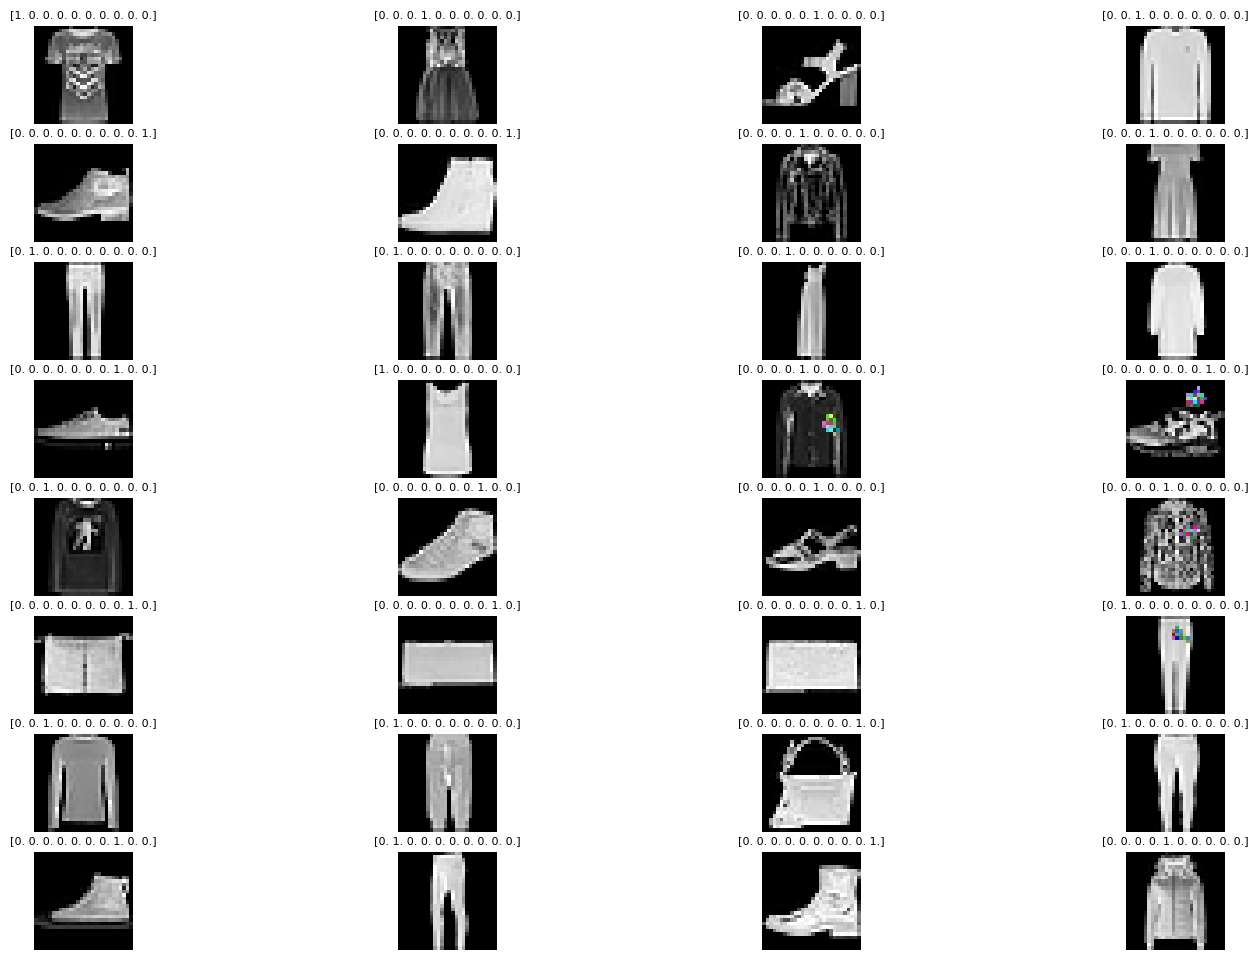

In [8]:
polygon_cutout = PolygonCutout(max_size_ratio=0.2, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=False, soft_label=False)

batch_x, batch_y = generator[0]

def denormalize(x):
    x = x.copy()
    x = np.clip(x * 255.0, 0, 255)
    return x.astype(np.uint8)

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## CNN: max size = 0.2
Without soft labels

In [9]:
polygon_cutout = PolygonCutout(max_size_ratio=0.2, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [10]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - accuracy: 0.8076 - loss: 0.5873 - val_accuracy: 0.8978 - val_loss: 0.2808
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9047 - loss: 0.2653 - val_accuracy: 0.9003 - val_loss: 0.2798
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9203 - loss: 0.2218 - val_accuracy: 0.9076 - val_loss: 0.2584
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9292 - loss: 0.1941 - val_accuracy: 0.9153 - val_loss: 0.2293
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9401 - loss: 0.1650 - val_accuracy: 0.9243 - val_loss: 0.2172
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9482 - loss: 0.1409 - val_accuracy: 0.9238 - val_loss: 0.2280


### Model statistics

In [12]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1000
           1       1.00      0.99      0.99      1000
           2       0.83      0.93      0.88      1000
           3       0.95      0.90      0.92      1000
           4       0.90      0.84      0.87      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.76      0.78      1000
           7       0.95      0.99      0.97      1000
           8       0.98      0.99      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



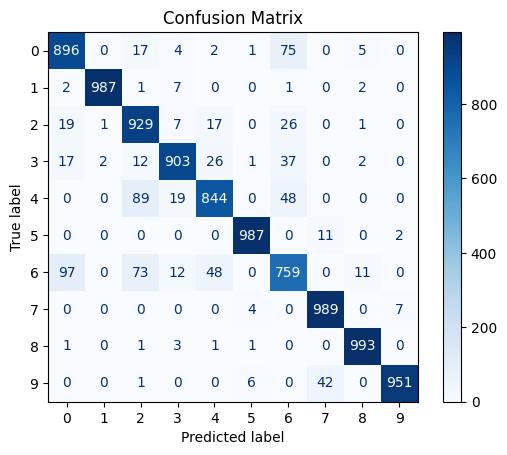

In [13]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9464
Final Validation Accuracy: 0.9238


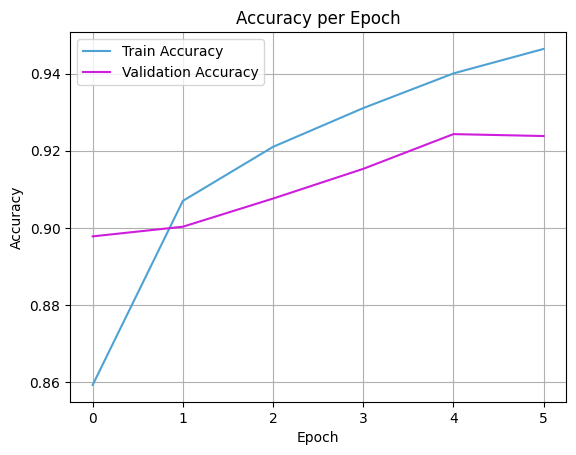

In [14]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [15]:
model.save('polygon_normal_labels_02.keras')

## CNN: max size = 0.1
Without soft labels

In [36]:
polygon_cutout = PolygonCutout(max_size_ratio=0.1, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [37]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [38]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8068 - loss: 0.6016 - val_accuracy: 0.8818 - val_loss: 0.3570
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9017 - loss: 0.2697 - val_accuracy: 0.9053 - val_loss: 0.2592
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9200 - loss: 0.2243 - val_accuracy: 0.9188 - val_loss: 0.2222
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9296 - loss: 0.1921 - val_accuracy: 0.9190 - val_loss: 0.2260
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9417 - loss: 0.1593 - val_accuracy: 0.9080 - val_loss: 0.2665
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9465 - loss: 0.1433 - val_accuracy: 0.9274 - val_loss: 0.2104


### Model statistics

In [39]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1000
           1       1.00      0.99      0.99      1000
           2       0.88      0.92      0.90      1000
           3       0.91      0.94      0.92      1000
           4       0.91      0.86      0.88      1000
           5       0.98      0.99      0.98      1000
           6       0.76      0.83      0.79      1000
           7       0.96      0.97      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



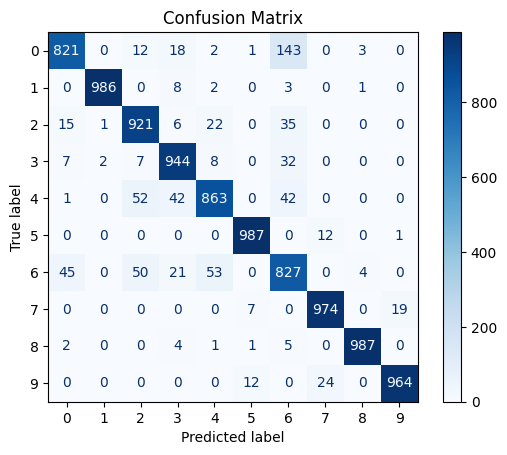

In [40]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9461
Final Validation Accuracy: 0.9274


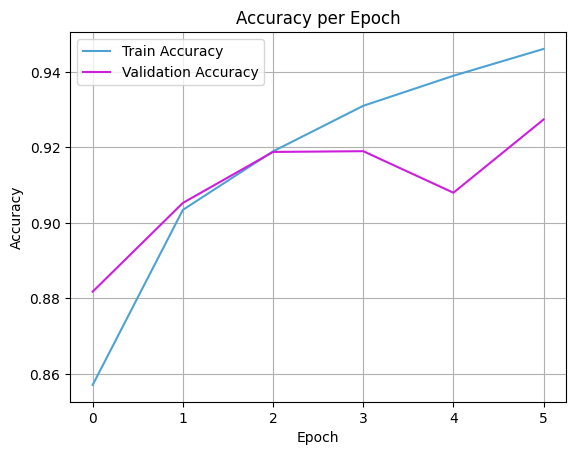

In [41]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [42]:
model.save('polygon_normal_labels_01.keras')

## CNN: max size = 0.05
Without soft labels

In [43]:
polygon_cutout = PolygonCutout(max_size_ratio=0.05, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=False)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [44]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [45]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8093 - loss: 0.6011 - val_accuracy: 0.8781 - val_loss: 0.3246
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9026 - loss: 0.2709 - val_accuracy: 0.9036 - val_loss: 0.2810
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9185 - loss: 0.2254 - val_accuracy: 0.9063 - val_loss: 0.2559
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9328 - loss: 0.1850 - val_accuracy: 0.9156 - val_loss: 0.2475
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9419 - loss: 0.1618 - val_accuracy: 0.9204 - val_loss: 0.2357
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9482 - loss: 0.1395 - val_accuracy: 0.9064 - val_loss: 0.2711


### Model statistics

In [46]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.95      0.73      0.83      1000
           3       0.91      0.94      0.92      1000
           4       0.83      0.81      0.82      1000
           5       0.99      0.97      0.98      1000
           6       0.64      0.86      0.74      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.91      0.91     10000



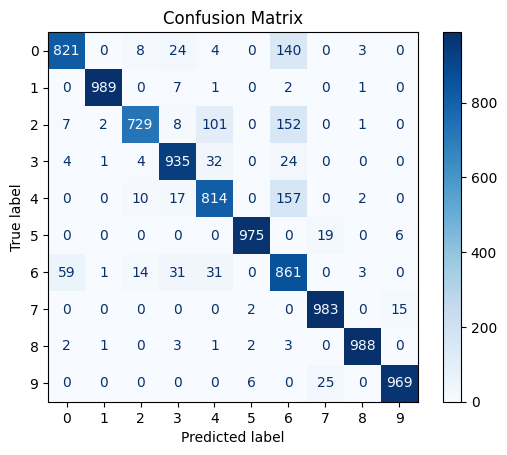

In [47]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9472
Final Validation Accuracy: 0.9064


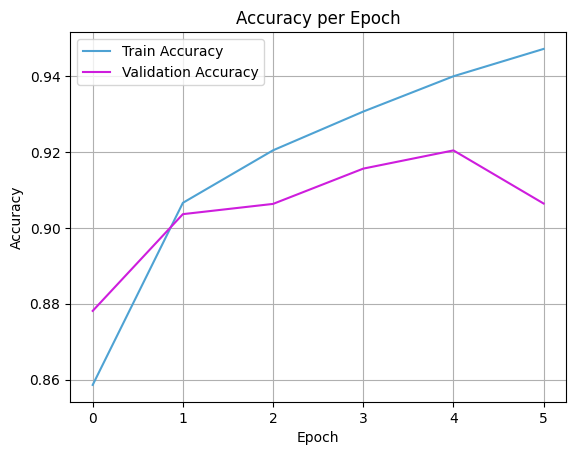

In [48]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [49]:
model.save('polygon_normal_labels_005.keras')

## CNN: max size = 0.05
With soft labels

In [50]:
polygon_cutout = PolygonCutout(max_size_ratio=0.05, random_color=True)

train_generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=32, shuffle=True, augmentor=polygon_cutout, augment_fraction=0.2, num_classes=10, overwrite=False, soft_label=True)
test_generator = AugmentedCIFAR10Generator(X_test, Y_test, batch_size=32, augmentor=None, shuffle=False)

In [51]:
k = 10
i = Input(shape=X_train[0].shape)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dropout(0.25)(x)

#hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.25)(x)

#last hidden layer i.e.. output layer
x = Dense(k, activation='softmax')(x)

model = Model(i, x)

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

r = model.fit(
 train_generator, validation_data = test_generator, epochs=6)

Epoch 1/6


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8124 - loss: 0.5959 - val_accuracy: 0.8905 - val_loss: 0.3040
Epoch 2/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9019 - loss: 0.2689 - val_accuracy: 0.9072 - val_loss: 0.2569
Epoch 3/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9181 - loss: 0.2255 - val_accuracy: 0.9045 - val_loss: 0.2706
Epoch 4/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9311 - loss: 0.1896 - val_accuracy: 0.9057 - val_loss: 0.2565
Epoch 5/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.9402 - loss: 0.1637 - val_accuracy: 0.9245 - val_loss: 0.2068
Epoch 6/6
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9484 - loss: 0.1369 - val_accuracy: 0.9193 - val_loss: 0.2284


### Model statistics

In [53]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1000
           1       1.00      0.98      0.99      1000
           2       0.93      0.87      0.90      1000
           3       0.93      0.91      0.92      1000
           4       0.78      0.96      0.86      1000
           5       0.99      0.97      0.98      1000
           6       0.79      0.72      0.76      1000
           7       0.95      0.98      0.97      1000
           8       0.98      0.99      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



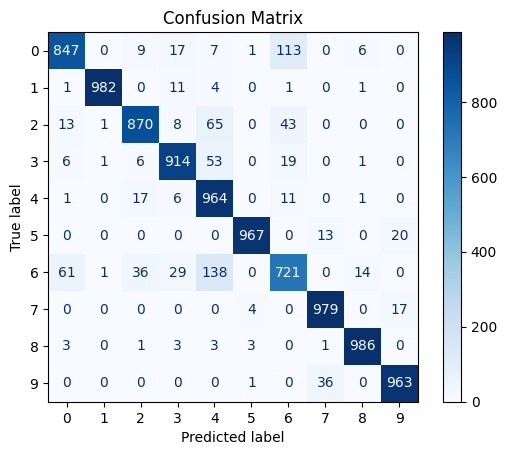

In [54]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9473
Final Validation Accuracy: 0.9193


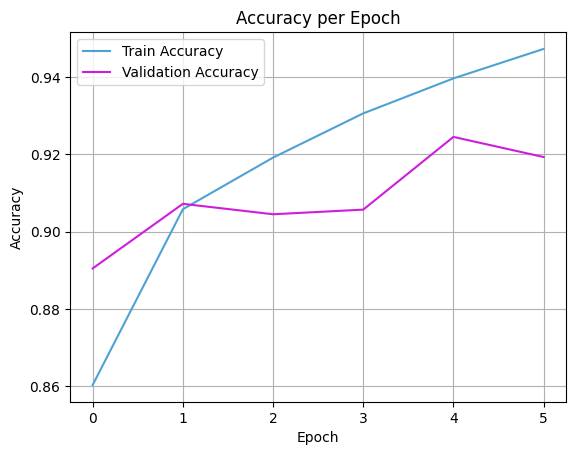

In [55]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [58]:
model.save('polygon_soft_labels_005.keras')

trying more epochs for soft labeling

In [59]:
r = model.fit(
 train_generator, validation_data = test_generator, epochs=4)

Epoch 1/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9572 - loss: 0.1151 - val_accuracy: 0.9296 - val_loss: 0.2204
Epoch 2/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9615 - loss: 0.1060 - val_accuracy: 0.9263 - val_loss: 0.2340
Epoch 3/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.9672 - loss: 0.0890 - val_accuracy: 0.9257 - val_loss: 0.2189
Epoch 4/4
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9699 - loss: 0.0804 - val_accuracy: 0.9332 - val_loss: 0.2336


In [60]:
y_pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(test_generator.y_combined, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.89      0.92      0.90      1000
           3       0.92      0.95      0.93      1000
           4       0.88      0.92      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.84      0.74      0.79      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



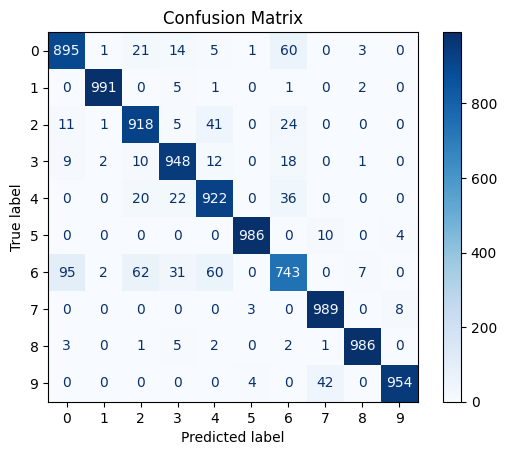

In [61]:
print(classification_report(y_true, y_pred_classes))
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Final Training Accuracy: 0.9696
Final Validation Accuracy: 0.9332


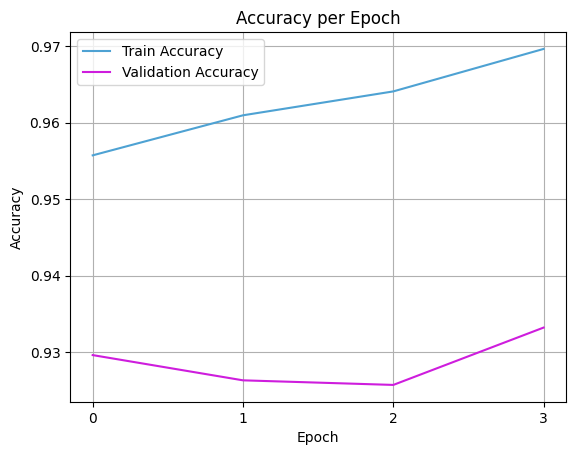

In [62]:
print(f"Final Training Accuracy: {r.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {r.history['val_accuracy'][-1]:.4f}")
plt.plot(r.history['accuracy'], label='Train Accuracy', color = '#4ea2d3')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy', color = '#ce1ddd')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
epochs = len(r.history['accuracy'])
plt.xticks(ticks=range(epochs))
plt.grid(True)
plt.show()

In [63]:
model.save('polygon_soft_labels_005_more_epochs.keras')